In [2]:
import os
import pandas as pd
import re
import pyLDAvis.sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.model_selection import train_test_split

import spacy

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/nest.py:1286: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  _pywrap_tensorflow.RegisterType("Mapping", _collections.Mapping)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/util/nest.py:1287: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  _pywrap_tensorflow.RegisterType("Sequence", _collections.Sequence)
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (ty

In [4]:
os.chdir('/Users/Ethan/Downloads/project/Modeling-Text/Train')

In [5]:
data = os.listdir()[1]
data

'full_clean_data.csv'

In [6]:
df1 = pd.read_csv(data)

def generate_df(df, target):
    full_df = df[target.notnull()]
    print('Generated df shape where target values are not null: ', full_df.shape)
    print('------------------------------')
    full_df.drop(columns='Unnamed: 0', inplace=True)
    print(full_df.head())
    
    return full_df

df = generate_df(df1, df1['label3'])

Generated df shape where target values are not null:  (8051, 15)
------------------------------
       username                                              tweet  \
0    obese_dyke  self diagnosed severe depression add insomnia ...   
1    lidsrodney        diagnosed bipolar getting harassed admin bi   
2     xandraris  oh fuck diagnosed bipolar even crazier thought...   
3  djtonythrill       dont care people bipolar til child diagnosed   
4    blt_rt_bot  ellletstalk two yrs diagnosed w bipolar manic ...   

  username_of_retweeter                                          hashtag  \
0            __xlovebri      [{'text': 'Empire', 'indices': [131, 138]}]   
1            __xlovebri      [{'text': 'Empire', 'indices': [131, 138]}]   
2            __xlovebri      [{'text': 'Empire', 'indices': [131, 138]}]   
3            __xlovebri      [{'text': 'Empire', 'indices': [131, 138]}]   
4            moyetsandy  [{'text': 'bellletstalk', 'indices': [16, 29]}]   

  tweet created  number of

In [7]:
def extract_features(text, vectorizer_type=None):
    
    if vectorizer_type == 'Count':
        vectorizer = CountVectorizer(min_df=5, stop_words='english', ngram_range=(1,2))
        tf = vectorizer.fit_transform(text.values.astype('U'))
        tf_feature_names = vectorizer.get_feature_names()
        doc_term_matrix = pd.DataFrame(tf.toarray(), columns=list(tf_feature_names))
    else:
        vectorizer = TfidfVectorizer(min_df=5, stop_words='english', ngram_range=(1,2))
        tf = vectorizer.fit_transform(text.values.astype('U'))
        tf_feature_names = vectorizer.get_feature_names()
        doc_term_matrix = pd.DataFrame(tf.toarray(), columns=list(tf_feature_names))
    
    print(tf.shape)
    print("total number of words in vocabulary:", len(vectorizer.vocabulary_)) 
    
    return vectorizer, doc_term_matrix

    # lda_model = LatentDirichletAllocation(n_components=2, learning_method='online', max_iter=100, random_state=0).fit(tf)
    # no_top_words = 100

    # pyLDAvis.enable_notebook()
    # panel = pyLDAvis.sklearn.prepare(lda_model, tf, tf_vectorizer, mds='tsne')
    # print(panel)

In [8]:
vect, dtm = extract_features(df['tweet'], 'Tfidf')

(8051, 5543)
total number of words in vocabulary: 5543


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# Model Preparation
- Encode the label column of df where 1 = diagnosed; 0 = not diagnosed
- Select features to include in text models

In [9]:
df[['tweet', 'label3']].sample(10)

,tweet,label3
6045,formerly homeless ex drug addict w bipolar dis...,not diagnosed
19,u diagnosed w bipolar disorder come support gr...,diagnosed
7650,ten million people u bipolar disorder people c...,not diagnosed
5237,cade apologies intended insult bipolar diagnos...,not diagnosed
5648,bipolar person know debate,not diagnosed
1655,pilocytic astrocytoma grade bipolar neoplastic...,diagnosed
7845,know meant episodes diagnosed bipolar disorder...,not diagnosed
4939,actually bipolar teenager might consider googl...,not diagnosed
2764,bipolar mine diagnosed unfortunate block car c...,diagnosed
85,waiting diagnosed bipolar disorderfya,diagnosed


In [10]:
dtm.shape

(8051, 5543)

In [15]:
# To preserve anonymity of usernames, we replace each handle with the string 'username'
df['username'] = df['username'].replace(df['username'].tolist(), 'username')
df['username']

0       username
1       username
2       username
3       username
4       username
          ...   
8046    username
8047    username
8048    username
8049    username
8050    username
Name: username, Length: 8051, dtype: object

In [16]:
from sklearn import preprocessing 

le = preprocessing.LabelEncoder()
df['encoded label'] = le.fit_transform(df['label3']) 
df

,username,tweet,username_of_retweeter,hashtag,tweet created,number of followers,# following,label,Polarity,Polarity_cat,len_tweet,word_count_tweet,label2,label3,encoded label
0,username,self diagnosed severe depression add insomnia ...,__xlovebri,"[{'text': 'Empire', 'indices': [131, 138]}]",2017-02-01,54.0,18.0,['diagnosed with'],0.000000,Neutral,117.0,14.0,'diagnosed with',diagnosed,0
1,username,diagnosed bipolar getting harassed admin bi,__xlovebri,"[{'text': 'Empire', 'indices': [131, 138]}]",2017-01-31,5012.0,4678.0,"['diagnosed with', 'diagnosed with bipolar']",0.000000,Neutral,43.0,6.0,"'diagnosed with', 'diagnosed with bipolar'",diagnosed,0
2,username,oh fuck diagnosed bipolar even crazier thought...,__xlovebri,"[{'text': 'Empire', 'indices': [131, 138]}]",2017-01-31,228.0,779.0,"['got diagnosed', 'diagnosed with', 'diagnosed...",-0.300000,Negative,66.0,11.0,"'got diagnosed', 'diagnosed with', 'diagnosed ...",diagnosed,0
3,username,dont care people bipolar til child diagnosed,__xlovebri,"[{'text': 'Empire', 'indices': [131, 138]}]",2017-01-31,210.0,550.0,['diagnosed with'],0.000000,Neutral,44.0,7.0,'diagnosed with',diagnosed,0
4,username,ellletstalk two yrs diagnosed w bipolar manic ...,moyetsandy,"[{'text': 'bellletstalk', 'indices': [16, 29]}]",2017-01-31,218.0,0.0,['diagnosed with'],-0.400000,Negative,84.0,13.0,'diagnosed with',diagnosed,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8046,username,NaN,felicindacluney,"[{'text': 'babe', 'indices': [0, 5]}]",2017-03-01,537.0,563.0,['never been diagnosed'],0.000000,Neutral,0.0,1.0,'never been diagnosed',not diagnosed,1
8047,username,NaN,felicindacluney,"[{'text': 'babe', 'indices': [0, 5]}]",2017-03-01,518.0,813.0,['never been diagnosed'],0.000000,Neutral,0.0,1.0,'never been diagnosed',not diagnosed,1
8048,username,happens house stays house check trailer wild n...,moceanla,"[{'text': 'babe', 'indices': [0, 5]}]",2017-03-01,187.0,5001.0,['never been diagnosed'],0.118182,Positive,69.0,10.0,'never been diagnosed',not diagnosed,1
8049,username,irthday party decorations batman babyshowerdis...,moceanla,"[{'text': 'babyshowerdisney', 'indices': [61, ...",2017-03-01,7.0,1.0,['never been diagnosed'],0.000000,Neutral,66.0,6.0,'never been diagnosed',not diagnosed,1


In [17]:
df.drop('encoded label', axis=1, inplace=True)

In [18]:
df

,username,tweet,username_of_retweeter,hashtag,tweet created,number of followers,# following,label,Polarity,Polarity_cat,len_tweet,word_count_tweet,label2,label3
0,username,self diagnosed severe depression add insomnia ...,__xlovebri,"[{'text': 'Empire', 'indices': [131, 138]}]",2017-02-01,54.0,18.0,['diagnosed with'],0.000000,Neutral,117.0,14.0,'diagnosed with',diagnosed
1,username,diagnosed bipolar getting harassed admin bi,__xlovebri,"[{'text': 'Empire', 'indices': [131, 138]}]",2017-01-31,5012.0,4678.0,"['diagnosed with', 'diagnosed with bipolar']",0.000000,Neutral,43.0,6.0,"'diagnosed with', 'diagnosed with bipolar'",diagnosed
2,username,oh fuck diagnosed bipolar even crazier thought...,__xlovebri,"[{'text': 'Empire', 'indices': [131, 138]}]",2017-01-31,228.0,779.0,"['got diagnosed', 'diagnosed with', 'diagnosed...",-0.300000,Negative,66.0,11.0,"'got diagnosed', 'diagnosed with', 'diagnosed ...",diagnosed
3,username,dont care people bipolar til child diagnosed,__xlovebri,"[{'text': 'Empire', 'indices': [131, 138]}]",2017-01-31,210.0,550.0,['diagnosed with'],0.000000,Neutral,44.0,7.0,'diagnosed with',diagnosed
4,username,ellletstalk two yrs diagnosed w bipolar manic ...,moyetsandy,"[{'text': 'bellletstalk', 'indices': [16, 29]}]",2017-01-31,218.0,0.0,['diagnosed with'],-0.400000,Negative,84.0,13.0,'diagnosed with',diagnosed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8046,username,NaN,felicindacluney,"[{'text': 'babe', 'indices': [0, 5]}]",2017-03-01,537.0,563.0,['never been diagnosed'],0.000000,Neutral,0.0,1.0,'never been diagnosed',not diagnosed
8047,username,NaN,felicindacluney,"[{'text': 'babe', 'indices': [0, 5]}]",2017-03-01,518.0,813.0,['never been diagnosed'],0.000000,Neutral,0.0,1.0,'never been diagnosed',not diagnosed
8048,username,happens house stays house check trailer wild n...,moceanla,"[{'text': 'babe', 'indices': [0, 5]}]",2017-03-01,187.0,5001.0,['never been diagnosed'],0.118182,Positive,69.0,10.0,'never been diagnosed',not diagnosed
8049,username,irthday party decorations batman babyshowerdis...,moceanla,"[{'text': 'babyshowerdisney', 'indices': [61, ...",2017-03-01,7.0,1.0,['never been diagnosed'],0.000000,Neutral,66.0,6.0,'never been diagnosed',not diagnosed


In [19]:
enco_labs = {'not diagnosed': 0, 'diagnosed': 1}
df['encoded label'] = df['label3']
df = df.replace({'encoded label':enco_labs})
df

,username,tweet,username_of_retweeter,hashtag,tweet created,number of followers,# following,label,Polarity,Polarity_cat,len_tweet,word_count_tweet,label2,label3,encoded label
0,username,self diagnosed severe depression add insomnia ...,__xlovebri,"[{'text': 'Empire', 'indices': [131, 138]}]",2017-02-01,54.0,18.0,['diagnosed with'],0.000000,Neutral,117.0,14.0,'diagnosed with',diagnosed,1
1,username,diagnosed bipolar getting harassed admin bi,__xlovebri,"[{'text': 'Empire', 'indices': [131, 138]}]",2017-01-31,5012.0,4678.0,"['diagnosed with', 'diagnosed with bipolar']",0.000000,Neutral,43.0,6.0,"'diagnosed with', 'diagnosed with bipolar'",diagnosed,1
2,username,oh fuck diagnosed bipolar even crazier thought...,__xlovebri,"[{'text': 'Empire', 'indices': [131, 138]}]",2017-01-31,228.0,779.0,"['got diagnosed', 'diagnosed with', 'diagnosed...",-0.300000,Negative,66.0,11.0,"'got diagnosed', 'diagnosed with', 'diagnosed ...",diagnosed,1
3,username,dont care people bipolar til child diagnosed,__xlovebri,"[{'text': 'Empire', 'indices': [131, 138]}]",2017-01-31,210.0,550.0,['diagnosed with'],0.000000,Neutral,44.0,7.0,'diagnosed with',diagnosed,1
4,username,ellletstalk two yrs diagnosed w bipolar manic ...,moyetsandy,"[{'text': 'bellletstalk', 'indices': [16, 29]}]",2017-01-31,218.0,0.0,['diagnosed with'],-0.400000,Negative,84.0,13.0,'diagnosed with',diagnosed,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8046,username,NaN,felicindacluney,"[{'text': 'babe', 'indices': [0, 5]}]",2017-03-01,537.0,563.0,['never been diagnosed'],0.000000,Neutral,0.0,1.0,'never been diagnosed',not diagnosed,0
8047,username,NaN,felicindacluney,"[{'text': 'babe', 'indices': [0, 5]}]",2017-03-01,518.0,813.0,['never been diagnosed'],0.000000,Neutral,0.0,1.0,'never been diagnosed',not diagnosed,0
8048,username,happens house stays house check trailer wild n...,moceanla,"[{'text': 'babe', 'indices': [0, 5]}]",2017-03-01,187.0,5001.0,['never been diagnosed'],0.118182,Positive,69.0,10.0,'never been diagnosed',not diagnosed,0
8049,username,irthday party decorations batman babyshowerdis...,moceanla,"[{'text': 'babyshowerdisney', 'indices': [61, ...",2017-03-01,7.0,1.0,['never been diagnosed'],0.000000,Neutral,66.0,6.0,'never been diagnosed',not diagnosed,0


# Multinomial Naive Bayes Model

In [79]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(dtm, df['encoded label'], test_size = 0.2, random_state = 0)
nb_clf = MultinomialNB().fit(X_train, y_train)

predicted = nb_clf.predict(X_test)
print(predicted[0:10])
y_test[0:10]

[1 1 1 1 1 1 1 1 1 1]


1515    1
5841    0
276     1
5304    0
2378    1
629     1
2891    1
7111    1
4824    0
989     1
Name: encoded label, dtype: int64

### Classification Report

In [80]:
labels = sorted(df['encoded label'].unique())
precision, recall, fscore, support = precision_recall_fscore_support(y_test, predicted, labels=labels)
print("labels: ", labels)
print("precision: ", precision)
print("recall: ", recall)
print("f-score: ", fscore)
print("support: ", support)

print(classification_report(y_test, predicted))#, target_names=labels

labels:  [0, 1]
precision:  [0.82651391 0.735     ]
recall:  [0.65584416 0.87395957]
f-score:  [0.73135409 0.79847909]
support:  [770 841]
              precision    recall  f1-score   support

           0       0.83      0.66      0.73       770
           1       0.73      0.87      0.80       841

    accuracy                           0.77      1611
   macro avg       0.78      0.76      0.76      1611
weighted avg       0.78      0.77      0.77      1611



### Grid Search Parameter Tuning

In [82]:
# grid search parameter tuning

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score

text_clf = Pipeline([('tfidf', TfidfVectorizer()), ('nb_clf', MultinomialNB())])
params = {'tfidf__min_df':[1, 2, 5, 10, 15], 'tfidf__stop_words': [None, 'english'], 'nb_clf__alpha': [0, 0.5, 1.0, 1.5, 2.0],}
metric = make_scorer(fbeta_score, beta=2)
gs_clf = GridSearchCV(text_clf, param_grid = params, scoring = metric, cv = 5)
gs_clf = gs_clf.fit(df["tweet"].values.astype('U'), df["encoded label"])

C:\Users\skord\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\skord\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\skord\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\skord\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\skord\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\skord\Anaconda3\lib\s

C:\Users\skord\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\skord\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\skord\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\skord\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\skord\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\skord\Anaconda3\lib\s

In [83]:
for param_name in gs_clf.best_params_:
    print("{0}:\t{1}".format(param_name, gs_clf.best_params_[param_name]))
print("best f1 score: {:.3f}".format(gs_clf.best_score_))

nb_clf__alpha:	2.0
tfidf__min_df:	1
tfidf__stop_words:	english
best f1 score: 0.720


Precision is an evalutation metric that calculates the percentage of correct predictions for the positive class. Recall is an evaluation metric that calculates the percentage of correct predictions for the positive class out of all the positive predictions that could be made. Maximizing precision will effectively minimize the false positives (type-1 errors) whereas maximizing the recall will minimize the false negatives (type-2 errors).

In our case, we want to increase the number of bipolar disorder classifications and lower the number of type 2 errors. The F1 score does not help us in this task as it puts an emphasis on maximizing the precision, which in turn, minimizes the false positives. Our main evalution metric is thus the F2 score, which will maximize recall and minimize the false negatives. Based on the F2 score, we can determine the best performing classifier. Given below is the F2 score of our classifier:

In [84]:
fbeta_score(y_test, predicted, beta=2)

0.8421173235563703

### Best Parameter Implementation

In [85]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(dtm, df['encoded label'], test_size = 0.2, random_state = 0)
nb_clf = MultinomialNB(alpha = 2.0).fit(X_train, y_train)

predicted = nb_clf.predict(X_test)
print(predicted[0:10])
y_test[0:10]

[1 1 1 0 1 1 1 1 1 1]


1515    1
5841    0
276     1
5304    0
2378    1
629     1
2891    1
7111    1
4824    0
989     1
Name: encoded label, dtype: int64

In [86]:
labels = sorted(df['encoded label'].unique())
precision, recall, fscore, support = precision_recall_fscore_support(y_test, predicted, labels=labels)
print("labels: ", labels)
print("precision: ", precision)
print("recall: ", recall)
print("f-score: ", fscore)
print("support: ", support)

print(classification_report(y_test, predicted))#, target_names=labels

labels:  [0, 1]
precision:  [0.83333333 0.72629521]
recall:  [0.63636364 0.88347206]
f-score:  [0.72164948 0.7972103 ]
support:  [770 841]
              precision    recall  f1-score   support

           0       0.83      0.64      0.72       770
           1       0.73      0.88      0.80       841

    accuracy                           0.77      1611
   macro avg       0.78      0.76      0.76      1611
weighted avg       0.78      0.77      0.76      1611



### Confusion Matrix

Text(0.5, 1, 'Confusion Matrix')

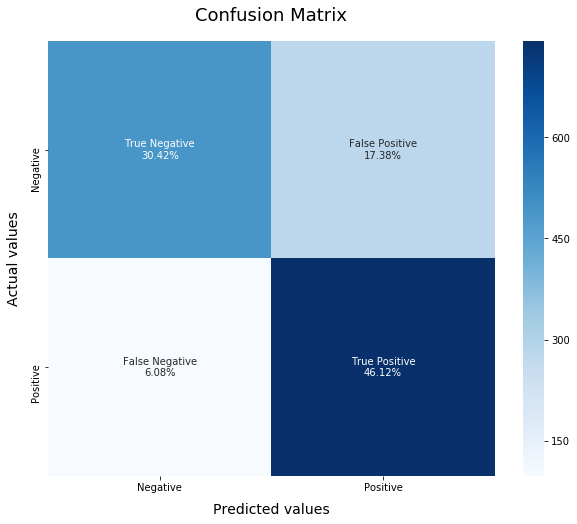

In [87]:
# sns confusion matrix

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, predicted)
categories = ['Negative', 'Positive']
group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
group_percentages = ['{0:.2%}'.format(value) for value in conf_mat.flatten()/np.sum(conf_mat)]
labs = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_percentages)]
labs = np.asarray(labs).reshape(2, 2)
plt.figure(figsize=(10,8))
ax = sns.heatmap(conf_mat, annot = labs, cmap = 'Blues', fmt = '', xticklabels = categories, yticklabels = categories)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom+0.5, top-0.5)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values", fontdict = {'size':14}, labelpad = 10)
plt.title("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [88]:
print(confusion_matrix(y_test, predicted))

[[490 280]
 [ 98 743]]


### AUC Plot

In [89]:
# AUC

from sklearn.metrics import roc_curve, auc,precision_recall_curve
import numpy as np

pred_prob = nb_clf.predict_proba(X_test)
labels
pred_prob[0:3]
y_test[0:3]

binary_y = np.where(y_test, 1, 0)
y_pred = pred_prob[:,1]

fpr, tpr, thresholds = roc_curve(binary_y, y_pred, pos_label = 1)

print("AUC: {:2%}".format(auc(fpr, tpr)))

AUC: 86.902883%


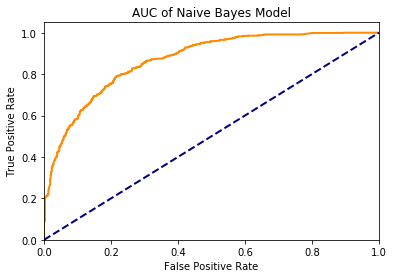

In [90]:
from matplotlib import pyplot as plt
plt.figure();
plt.plot(fpr, tpr, color='darkorange', lw=2);
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('AUC of Naive Bayes Model');
plt.show();

### Precision-Recall Plot

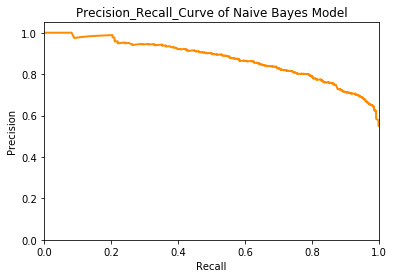

Average Precision: 87.48%


In [91]:
# precision recall curve

precision, recall, thresholds = precision_recall_curve(binary_y, y_pred, pos_label=1)

plt.figure();
plt.plot(recall, precision, color='darkorange', lw=2);
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel('Recall');
plt.ylabel('Precision');
plt.title('Precision_Recall_Curve of Naive Bayes Model');
plt.show();

print("Average Precision: {:.2%}".format(auc(recall, precision)))

# Linear SVM Model

In [71]:
# linear SVC/SVM

from sklearn.svm import LinearSVC
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(dtm, df['encoded label'], test_size = 0.2, random_state = 0)
svm_clf = LinearSVC().fit(X_train, y_train)

predicted = svm_clf.predict(X_test)
print(predicted[0:10])
y_test[0:10]

[0 1 1 0 0 1 1 1 0 1]


1515    1
5841    0
276     1
5304    0
2378    1
629     1
2891    1
7111    1
4824    0
989     1
Name: encoded label, dtype: int64

### Classification Report

In [72]:
labels = sorted(df['encoded label'].unique())
precision, recall, fscore, support = precision_recall_fscore_support(y_test, predicted, labels=labels)
print("labels: ", labels)
print("precision: ", precision)
print("recall: ", recall)
print("f-score: ", fscore)
print("support: ", support)

print(classification_report(y_test, predicted))

labels:  [0, 1]
precision:  [0.79354839 0.8145933 ]
recall:  [0.7987013 0.8097503]
f-score:  [0.7961165  0.81216458]
support:  [770 841]
              precision    recall  f1-score   support

           0       0.79      0.80      0.80       770
           1       0.81      0.81      0.81       841

    accuracy                           0.80      1611
   macro avg       0.80      0.80      0.80      1611
weighted avg       0.80      0.80      0.80      1611



### Grid Search Parameter Tuning

In [73]:
# grid search parameter tuning

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score

#f2_scorer = make_scorer(fbeta_score, beta=2)
#f2_scorer

text_clf = Pipeline([('tfidf', TfidfVectorizer()), ('svm_clf', LinearSVC())])
params = {'tfidf__min_df':[1, 2, 5, 10, 15], 'tfidf__stop_words': [None, 'english'], 'svm_clf__penalty': ['l2'], 'svm_clf__C': [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0], 'svm_clf__loss': ['hinge', 'squared_hinge'],}
metric = make_scorer(fbeta_score, beta=2)
gs_clf = GridSearchCV(text_clf, param_grid = params, scoring = metric, cv = 5, verbose = 1)
gs_clf = gs_clf.fit(df["tweet"].values.astype('U'), df["encoded label"])

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\skord\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\skord\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\skord\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\skord\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\skord\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear faile

In [74]:
for param_name in gs_clf.best_params_:
    print("{0}:\t{1}".format(param_name, gs_clf.best_params_[param_name]))
print("best f1 score: {:.3f}".format(gs_clf.best_score_))

svm_clf__C:	0.25
svm_clf__loss:	hinge
svm_clf__penalty:	l2
tfidf__min_df:	10
tfidf__stop_words:	None
best f1 score: 0.708


In [75]:
fbeta_score(y_test, predicted, beta=2)

0.8107142857142856

### Best Parameters Implementation

In [ ]:
# linear SVC/SVM

from sklearn.svm import LinearSVC
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(dtm, df['encoded label'], test_size = 0.2, random_state = 0)
svm_clf = LinearSVC().fit(X_train, y_train)

predicted = svm_clf.predict(X_test)
print(predicted[0:10])
y_test[0:10]

In [76]:
labels = sorted(df['encoded label'].unique())
precision, recall, fscore, support = precision_recall_fscore_support(y_test, predicted, labels=labels)
print("labels: ", labels)
print("precision: ", precision)
print("recall: ", recall)
print("f-score: ", fscore)
print("support: ", support)

print(classification_report(y_test, predicted))

labels:  [0, 1]
precision:  [0.79354839 0.8145933 ]
recall:  [0.7987013 0.8097503]
f-score:  [0.7961165  0.81216458]
support:  [770 841]
              precision    recall  f1-score   support

           0       0.79      0.80      0.80       770
           1       0.81      0.81      0.81       841

    accuracy                           0.80      1611
   macro avg       0.80      0.80      0.80      1611
weighted avg       0.80      0.80      0.80      1611



### Confusion Matrix

Text(0.5, 1, 'Confusion Matrix')

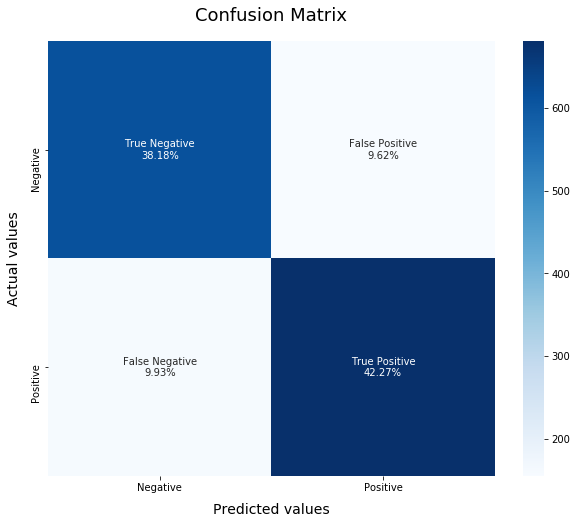

In [77]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, predicted)
categories = ['Negative', 'Positive']
group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
group_percentages = ['{0:.2%}'.format(value) for value in conf_mat.flatten()/np.sum(conf_mat)]
labs = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_percentages)]
labs = np.asarray(labs).reshape(2, 2)
plt.figure(figsize=(10,8))
ax = sns.heatmap(conf_mat, annot = labs, cmap = 'Blues', fmt = '', xticklabels = categories, yticklabels = categories)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom+0.5, top-0.5)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values", fontdict = {'size':14}, labelpad = 10)
plt.title("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [78]:
print(confusion_matrix(y_test, predicted))

[[615 155]
 [160 681]]


### AUC Plot

In [79]:
# AUC

from sklearn.metrics import roc_curve, auc,precision_recall_curve
import numpy as np

pred_prob = knn_clf.predict_proba(X_test)
labels
pred_prob[0:3]
y_test[0:3]

binary_y = np.where(y_test, 1, 0)
y_pred = pred_prob[:,1]

fpr, tpr, thresholds = roc_curve(binary_y, y_pred, pos_label = 1)

print("AUC: {:2%}".format(auc(fpr, tpr)))

AUC: 74.213907%


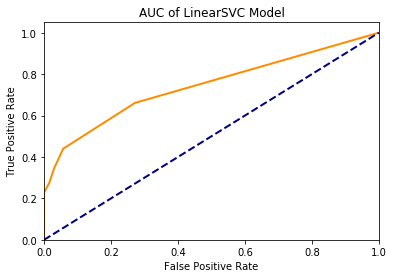

In [82]:
from matplotlib import pyplot as plt
plt.figure();
plt.plot(fpr, tpr, color='darkorange', lw=2);
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('AUC of LinearSVC Model');
plt.show();

### Precision-Recall Plot

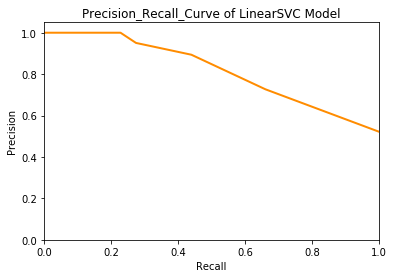

Average Precision: 81.68%


In [83]:
# precision recall curve

precision, recall, thresholds = precision_recall_curve(binary_y, y_pred, pos_label=1)

plt.figure();
plt.plot(recall, precision, color='darkorange', lw=2);
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel('Recall');
plt.ylabel('Precision');
plt.title('Precision_Recall_Curve of LinearSVC Model');
plt.show();

print("Average Precision: {:.2%}".format(auc(recall, precision)))

# Logistic Regression Model

In [31]:
# logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dtm, df['encoded label'], test_size = 0.2, random_state = 0)
lr_clf = LogisticRegression(C=10, penalty='l2', solver='newton-cg').fit(X_train, y_train)

predicted = lr_clf.predict(X_test)
print(predicted[0:10])
y_test[0:10]

[0 1 1 0 0 1 1 1 0 1]


1515    1
5841    0
276     1
5304    0
2378    1
629     1
2891    1
7111    1
4824    0
989     1
Name: encoded label, dtype: int64

### Classification Report

In [32]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

labels = sorted(df['encoded label'].unique())
precision, recall, fscore, support = precision_recall_fscore_support(y_test, predicted, labels=labels)
print("labels: ", labels)
print("precision: ", precision)
print("recall: ", recall)
print("f-score: ", fscore)
print("support: ", support)

print(classification_report(y_test, predicted))

labels:  [0, 1]
precision:  [0.7953668 0.8177458]
recall:  [0.8025974  0.81093936]
f-score:  [0.79896574 0.81432836]
support:  [770 841]
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       770
           1       0.82      0.81      0.81       841

    accuracy                           0.81      1611
   macro avg       0.81      0.81      0.81      1611
weighted avg       0.81      0.81      0.81      1611



### Grid Search Parameter Tuning

In [56]:
# grid search parameter tuning

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score

f2_scorer = make_scorer(fbeta_score, beta=2)
f2_scorer

text_clf = Pipeline([('tfidf', TfidfVectorizer()), ('lr_clf', LogisticRegression())])
params = {'tfidf__min_df':[1, 2, 5, 10, 15], 'tfidf__stop_words': [None, 'english'], 'lr_clf__penalty': ['l2'], 'lr_clf__C': [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0], 'lr_clf__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],}
metric = make_scorer(fbeta_score, beta=2)
gs_clf = GridSearchCV(text_clf, param_grid = params, scoring = metric, cv = 5, verbose = 1)
gs_clf = gs_clf.fit(df["tweet"].values.astype('U'), df["encoded label"])

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed:  4.7min finished


In [69]:
for param_name in gs_clf.best_params_:
    print("{0}:\t{1}".format(param_name, gs_clf.best_params_[param_name]))
print("best f1 score: {:.3f}".format(gs_clf.best_score_))
f2 = f2_func(y_test, predicted)
print("best f2 score: ", my_f2_scorer())

nb_clf__alpha:	1.0
tfidf__min_df:	5
tfidf__stop_words:	english
best f1 score: 0.592
best f2 score:  make_scorer(f2_func)


In [70]:
fbeta_score(y_test, predicted, beta=2)

0.8421173235563703

### Best Parameters Implementation

In [43]:
# logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dtm, df['encoded label'], test_size = 0.2, random_state = 0)
lr_clf = LogisticRegression(C=0.25, penalty='l2', solver='saga').fit(X_train, y_train)

predicted = lr_clf.predict(X_test)
print(predicted[0:10])
y_test[0:10]

[0 0 1 0 1 1 1 1 1 1]


1515    1
5841    0
276     1
5304    0
2378    1
629     1
2891    1
7111    1
4824    0
989     1
Name: encoded label, dtype: int64

In [44]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

labels = sorted(df['encoded label'].unique())
precision, recall, fscore, support = precision_recall_fscore_support(y_test, predicted, labels=labels)
print("labels: ", labels)
print("precision: ", precision)
print("recall: ", recall)
print("f-score: ", fscore)
print("support: ", support)

print(classification_report(y_test, predicted))

labels:  [0, 1]
precision:  [0.82147651 0.81755196]
recall:  [0.79480519 0.84185493]
f-score:  [0.80792079 0.82952548]
support:  [770 841]
              precision    recall  f1-score   support

           0       0.82      0.79      0.81       770
           1       0.82      0.84      0.83       841

    accuracy                           0.82      1611
   macro avg       0.82      0.82      0.82      1611
weighted avg       0.82      0.82      0.82      1611



### Confusion Matrix

Text(0.5, 1, 'Confusion Matrix')

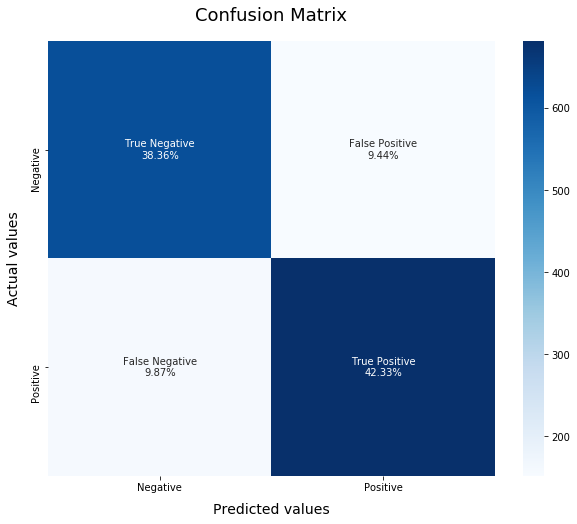

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, predicted)
categories = ['Negative', 'Positive']
group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
group_percentages = ['{0:.2%}'.format(value) for value in conf_mat.flatten()/np.sum(conf_mat)]
labs = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_percentages)]
labs = np.asarray(labs).reshape(2, 2)
plt.figure(figsize=(10,8))
ax = sns.heatmap(conf_mat, annot = labs, cmap = 'Blues', fmt = '', xticklabels = categories, yticklabels = categories)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom+0.5, top-0.5)
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values", fontdict = {'size':14}, labelpad = 10)
plt.title("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [34]:
print(confusion_matrix(y_test, predicted))

[[618 152]
 [159 682]]


### AUC Plot

In [35]:
# AUC

from sklearn.metrics import roc_curve, auc,precision_recall_curve
import numpy as np

pred_prob = lr_clf.predict_proba(X_test)
labels
pred_prob[0:3]
y_test[0:3]

binary_y = np.where(y_test, 1, 0)
y_pred = pred_prob[:,1]

fpr, tpr, thresholds = roc_curve(binary_y, y_pred, pos_label = 1)

print("AUC: {:2%}".format(auc(fpr, tpr)))

AUC: 88.517844%


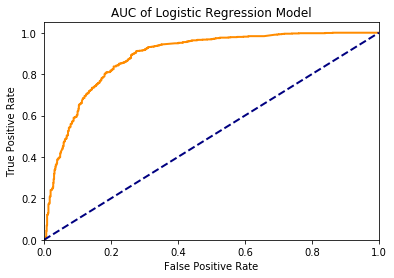

In [36]:
from matplotlib import pyplot as plt
plt.figure();
plt.plot(fpr, tpr, color='darkorange', lw=2);
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('AUC of Logistic Regression Model');
plt.show();

### Precision-Recall Plot

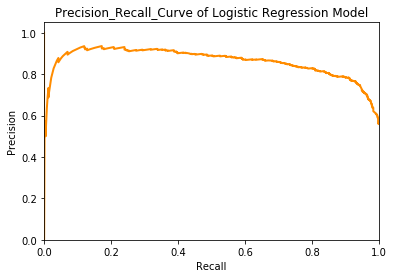

Average Precision: 85.94%


In [37]:
# precision recall curve

precision, recall, thresholds = precision_recall_curve(binary_y, y_pred, pos_label=1)

plt.figure();
plt.plot(recall, precision, color='darkorange', lw=2);
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel('Recall');
plt.ylabel('Precision');
plt.title('Precision_Recall_Curve of Logistic Regression Model');
plt.show();

print("Average Precision: {:.2%}".format(auc(recall, precision)))